In [1]:
from pennylane import numpy as np
import pennylane as qml
import pickle
import scipy
from scipy.linalg import eigh
from scipy.linalg import det

## Molecule definition

In [2]:
def angstrom_to_bohr(dist):
    return dist*1.88973

In [3]:
n_electrons = 4
n_orbitals = 6

symbols = ["H", "Be", "H"]
coordinates = angstrom_to_bohr(np.array([0.0, 0.0, -1.3264, 0.0, 0.0,0.0, 0.0, 0.0, 1.3264], requires_grad=False))


In [4]:

#H, qubits = qml.qchem.molecular_hamiltonian(mol.symbols,
#                                            mol.coordinates,
#                                            active_electrons=active_electrons,
#                                            active_orbitals=active_orbitals,
#                                                      grouping_method = 'qwc',
#                                                      args=[mol.coordinates])
H, qubits =  qml.qchem.molecular_hamiltonian(symbols,
                                                coordinates,
                                                basis='sto-3G',
                                                active_electrons=n_electrons,
                                                active_orbitals=n_orbitals)

In [5]:
generators = qml.symmetry_generators(H)
paulixops = qml.paulix_ops(generators, qubits)
paulix_sector = qml.qchem.optimal_sector(H, generators, n_electrons)

H_tapered_oldwires = qml.taper(H, generators, paulixops, paulix_sector)

/Users/Brian/workspace/Research/QHack2023/.conda/lib/python3.10/site-packages/pennylane/operation.py:1830: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(
/Users/Brian/workspace/Research/QHack2023/.conda/lib/python3.10/site-packages/pennylane/operation.py:1993: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(


In [6]:
qubits_tap = qubits-len(paulixops)
wire_tapered = [ paulixops[i].wires[0] for i in range(len(paulixops))]
wire_tap = [ x for x in range(qubits) if not x in wire_tapered ]
wire_map = {wire:i for i,wire in enumerate(wire_tap)}


H_tapered = qml.map_wires(H_tapered_oldwires,wire_map)

In [7]:
with open('gs_vqe_ok.pkl','rb') as f:
    psi0 = pickle.load(f)

## Tools

In [8]:
def rewrite_pauli_word_to_string(pw,qubits=qubits_tap):
    #qml.pauli_word_to_string()
    s = dict(pw.items())
    string=''
    for i in range(qubits):
        if i in s.keys():
            string+=s[i]
        else:
            string+='I'
    return string

    #return ''.join(['I' if i not in pw.wires else el 
    #                for i,el in enumerate(qml.pauli.pauli_word_to_string(pw))])

def cumulative_space(H,K):
    if K==0:
    # just return pauli word identity
        return [''.join(['I' for _ in range(qubits_tap)])]

    else:
        Id = ''.join(['I' for _ in range(qubits_tap)])
        PsH = qml.pauli.pauli_sentence(H)
        PsH_real = qml.pauli.PauliSentence( { pw : 1. for  pw,_ in PsH.items()})
        # maybe ? PsH_real.simplify()
        PsH_cumul = qml.pauli.PauliSentence( { pw : 1. for  pw,_ in PsH.items()})

        CSK = {rewrite_pauli_word_to_string(pw) for pw,_ in (PsH).items()}
        
        for _ in range(K-1):
            PsH_cumul = PsH_cumul * PsH_real
            CSK.update(*[rewrite_pauli_word_to_string(pw) for pw,_ in (PsH_cumul*PsH_real).items()])

                
        #basis = [{''.join(['I' for _ in range(qubits_tap)])},CS1]
        #for _ in range(K-1):
        #    CSK.update(basis[-2])
        #    basis.append(  increment_cummulative_space( basis[-1].difference(a)  ,CS1)   )
        #CSK.update(*basis[-2:])
    CSK.remove(Id)
    return [Id]+list(CSK)



In [9]:
len(cumulative_space(H_tapered,1))
#qml.pauli.pauli_word_to_string(qml.Identity(0)@qml.PauliX(3))
#rewrite_pauli_word_to_string([pw for pw,_ in (PsH).items()][3]

#([ type(el) for el in H.ops][1])
#H.ops
#[pw for pw,_ in (PsH).items()][10]
#dict([pw for pw,_ in (PsH).items()][10].items())

268

In [10]:
import dask 
import time
# Calculate the expectation value with the inital state psi0
# Could be improved with Dask or QWC elements

devs = [ qml.device("default.qubit", wires=qubits_tap) for _ in range(len(H_tapered.ops))]


def circuit(Pi_H_Pj,psi0):
        qml.QubitStateVector(psi0, range(qubits_tap))
        return qml.expval(Pi_H_Pj)


def compute_circuit(Pi_H_Pj,psi0):
    dev = qml.device("default.qubit", wires=qubits_tap)
    @qml.qnode(dev)
    def circ(Pi_H_Pj,psi0):
        qml.QubitStateVector(psi0, range(qubits_tap))
        return qml.expval(Pi_H_Pj)
    return circ(Pi_H_Pj,psi0)

def compute_expect(H,psi0):
    qnode = qml.QNode(circuit, dev)(H,psi0)
    return qnode


def compute_energy_parallel(H, devs, param):
    assert len(H.ops) == len(devs)
    results = []

    for i in range(len(H.ops)):
        qnode = qml.QNode(circuit, devs[i])
        results.append(dask.delayed(qnode)(param, H.ops[i]))

    result = H.coeffs @ dask.compute(*results, scheduler="threads")
    return result


def compute_expect_parallel_optimized(H, devs=devs):
    assert len(H.ops) <= len(devs)
    results = []

    obs_groupings, coeffs_groupings = qml.pauli.group_observables(H.ops, H.coeffs, "qwc")
    for i, (obs, coeffs) in enumerate(zip(obs_groupings, coeffs_groupings)):
        # THE FOLLOWING CASE IS SURPRISINGLY HAPPENING SOMETIMES....
        #if(len(coeffs)!=len(obs)):
        #    print("lolilol ", len(coeffs)," ",coeffs, " ", len(obs), " ", obs )
        if(len(obs)> len(coeffs)):
            #print("AH")
            #print(type(coeffs))
            coeffs = qml.numpy.tensor( list(coeffs.unwrap()) + [0.+0.j for _ in range(len(obs)-len(coeffs))])
        
        H_part = qml.Hamiltonian(coeffs, obs)
        qnode = qml.QNode(circuit, devs[i])
        results.append(dask.delayed(qnode)(H_part))

    result = qml.math.sum(dask.compute(*results, scheduler="threads"))
    return result



In [11]:
def expectation_obs(Pi,Pj, H=qml.Hamiltonian(coeffs=[1.], observables = [qml.Identity(0)])):
    """Computes the expectation value of a Hamiltonian sandwiched between two Pauli words.


    Args:
        Pi (_type_): _description_
        Pj (_type_): _description_
        psi0 (_type_): _description_
        H (_type_, optional): _description_. Defaults to None.
        parallel (bool, optional): _description_. Defaults to False.
        nvidia (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    Pwi = qml.pauli.PauliWord(dict(zip(list(range(len(Pi))), Pi)))
    Pwj = qml.pauli.PauliWord(dict(zip(list(range(len(Pj))), Pj)))
    
    Psi = qml.pauli.PauliSentence({Pwi: 1.})
    Psj = qml.pauli.PauliSentence({Pwj: 1.})
    PsH = qml.pauli.pauli_sentence(H)

    Pi_H_Pj = Psi*PsH*Psj
    
    # BUG TO BE REPORTED : 
    # ps.Hamlitonian does not work in case ps contains complex coefficients: 
    # reproducer
    # pw1 = qml.pauli.PauliWord({0:"X"})
    # Psi = qml.pauli.PauliSentence({pw1: 1.,pw1: 1.2j})
    # Psi.hamiltonian()

    coeffs,ops = zip(*[ (coeff, pw.hamiltonian(wire_order=list(H_tapered.wires)).ops[0])  for pw, coeff in Pi_H_Pj.items()])

    #coeffs,ops = zip(*[ (coeff, pw.operation(wire_order=list(H_tapered.wires)))  for pw, coeff in Pi_H_Pj.items()])

    #obs_groupings, coeffs_groupings = qml.pauli.group_observables(ops, coeffs, 'qwc', 'rlf')

    #Pi_H_Pj = qml.Hamiltonian(coeffs = coeffs_groupings,
    #                            observables = obs_groupings)
    
    Pi_H_Pj = qml.Hamiltonian( coeffs = coeffs,
                                observables = ops,
                                grouping_type="qwc",
                                simplify=True
                            )
    
    
    return Pi_H_Pj


# Construct the overlap matrix S
def S_mat(basis):
    N = len(basis)
    S_mat = np.ones((N,N), dtype=complex)
    for i in range(N):
        for j in range(i):
            H = expectation_obs(basis[i],basis[j])
            S_mat[i,j] = compute_circuit(H,psi0)
            #H = expectation_obs(basis[i],basis[j],(i,j))[0]
            #S_mat[i,j] = compute_expect(H)
            S_mat[j,i] = S_mat[i,j].conjugate()
    return S_mat


# Construct the matrix D
def D_mat(basis, H_tapered):
    N = len(basis)
    D_mat = np.zeros((N,N), dtype=complex)

    #results = []
    for i in range(N):
        for j in range(i):
            #D_mat[i,j] = expectation_value(basis[i],basis[j],psi0, H=H_tapered)
            #t0 = time.time()
            H_temp = expectation_obs(basis[i],basis[j], H=H_tapered)

            #D_mat[i,j] = compute_expect(H_temp,psi0)
            
            D_mat[i,j] = compute_circuit(H_temp,psi0)
            #results.append(dask.delayed(expectation_obs)(basis[i],basis[j], (i,j),  H=H_tapered))
            D_mat[j,i] = D_mat[i,j].conjugate()

            #t1 = time.time() - t0
    #print("finished creating result")
    #result = dask.compute(*results, scheduler="threads")
    
    #print("finished computing result")
    #for el,idx in result:
    #    D_mat[idx] = compute_expect(el)  
    #    D_mat[idx[1],idx[0]] = D_mat[idx].conjugate()

            #t2 = time.time() - t0
        #if(i==0 and j==0):
            #print(f"Evaluation time operator: {t1:.2f} s")
            #print(f"Evaluation time expectation: {t2:.2f} s")
            
        H_temp = expectation_obs(basis[i],basis[i], H=H_tapered)      
        D_mat[i,i] = compute_circuit(H_temp,psi0).real
    return D_mat



In [12]:
Pj = 'XXIIIII'
Pwj = qml.pauli.PauliWord(dict(zip(list(range(len(Pj))), Pj)))
PsH = qml.pauli.pauli_sentence(H_tapered)
Psj = qml.pauli.PauliSentence({Pwj: 1+1.j})

for pw,coeff in (Psj*PsH).items():
    print(coeff)
    #print(a.hamiltonian(wire_order=list(H_tapered.wires)) )
    break

(-12.343105859033157-12.343105859033157j)


### Molecule

### Tapering

In [13]:
H_mat = qml.matrix(H_tapered)
vals, vects = eigh(H_mat)
print(vals[0])
#print(vects[0])
lmbda=[]
vectlol = vects.transpose() 

print(vectlol.shape)

for el in vectlol[:1]:
    lmbda.append((np.matmul(el.conj().transpose(),np.matmul(H_mat, el)) / np.matmul(el.conj().transpose(),el)).real)

print(min(lmbda))
print()
print((np.matmul(psi0.conj().transpose(),np.matmul(H_mat, psi0))/ np.matmul(psi0.conj().transpose(),psi0)) )


-15.594837897441872
(128, 128)
-15.59483789744188

(-15.594467553189197-1.232595164407934e-32j)


In [14]:
#expectation_obs('XII','III',(0,0),H=qml.Hamiltonian(coeffs=[1.j
#                                                            ,1.],observables=[qml.PauliZ(0)@qml.PauliY(1),qml.
#                                                                                PauliX(0)@qml.PauliY(1)]))[0]

### Generalized eigenvalue problem

In [46]:
basis = ['IIIIIII','XIIIIII','IXIIIII','IIXIIII','IIIXIII','IIIIXII','IIIIIXI','IIIIIIX']

basis = cumulative_space(H_tapered,1)

extract_basis = ['IIIIIII', 'ZZZIZZZ', 'IXZIIIZ', 'IYXIZZY', 'IZZXZXZ', 'YXIIYII', 'IYIXZZY']

#extract_basis = ['IIIIIII', 'IXZIIIZ']

print(extract_basis)
S = S_mat(extract_basis)
print(S)

['IIIIIII', 'ZZZIZZZ', 'IXZIIIZ', 'IYXIZZY', 'IZZXZXZ', 'YXIIYII', 'IYIXZZY']
[[ 1.00000000e+00+0.00000000e+00j -9.70792601e-01-0.00000000e+00j
   1.92872061e-02-0.00000000e+00j  8.54209076e-02-0.00000000e+00j
  -2.04380134e-05-0.00000000e+00j -1.06904187e-01-0.00000000e+00j
  -1.86136121e-02-0.00000000e+00j]
 [-9.70792601e-01+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   0.00000000e+00+1.90819582e-17j  0.00000000e+00+1.38777878e-17j
   0.00000000e+00-0.00000000e+00j  0.00000000e+00+2.35271871e-17j
   1.95080465e-03-0.00000000e+00j]
 [ 1.92872061e-02+0.00000000e+00j  0.00000000e+00-1.90819582e-17j
   1.00000000e+00+0.00000000e+00j  0.00000000e+00-1.01915004e-17j
   0.00000000e+00+2.77555756e-17j -1.11025695e-03-0.00000000e+00j
   2.75367567e-04-0.00000000e+00j]
 [ 8.54209076e-02+0.00000000e+00j  0.00000000e+00-1.38777878e-17j
   0.00000000e+00+1.01915004e-17j  1.00000000e+00+0.00000000e+00j
  -1.38558041e-05-0.00000000e+00j -4.39403407e-03-0.00000000e+00j
  -8.27840143e-02-0.00000

In [47]:
D = D_mat(extract_basis, H_tapered)

In [48]:
vals, vect = eigh(D,S, eigvals_only=False)
print(vals[0])

vect = vect.transpose()
#print(vect)

-15.596073510545837


In [49]:


#print(H)
#with open('gs_vqe_lolilol.pkl','rb') as f:
#    psi0 = pickle.load(f)

#dev = qml.device("default.qubit", wires=qubits_tap)
#@qml.qnode(dev)
#def circ(H):
#    qml.QubitStateVector(psi0, range(qubits_tap))
#    return qml.expval(qml.PauliX(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliY(6)@qml.PauliY(3))
#    #return qml.expval(H)


#circ(H)

In [50]:
#with open('gs_vqe_lolilol.pkl','rb') as f:
#    psi0 = pickle.load(f)
#print(np.around(psi0,3))

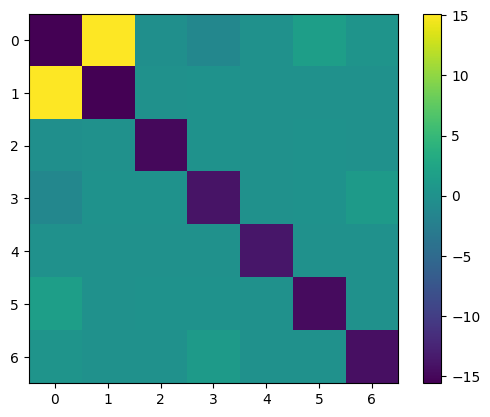

In [51]:
import matplotlib.pyplot as plt

plt.imshow(D.real)
plt.colorbar()

In [52]:
H = expectation_obs('IIIIIII', 'IXZIIIZ',H=H_tapered)


In [53]:
#print(list(zip(H.coeffs,H.ops)))
print(H)


  ((-0.021400299697140194+0j)) [Z3]
+ ((0.011739923719665903+0j)) [I0]
+ ((0.0812346693054344+0j)) [X1]
+ ((-0.4974044246250915+0j)) [X1 Z2]
+ ((-0.2510250268140925+0j)) [X1 Z6]
+ ((-0.017235466857783384+0j)) [X1 X3]
+ ((-0.011957152699294203+0j)) [Z2 Z3]
+ ((-0.011739923719665903+0j)) [Z6 Z0]
+ ((-0.004719497818336426+0j)) [Z4 Z5]
+ ((-0.0025497214710996302+0j)) [Z6 Z3]
+ (0.19866992324397587j) [Y1 Z2]
+ (0.10308486124301107j) [Y1 Z6]
+ (0.013973822258358023j) [Z3 Y6]
+ (0.10209297020704243j) [Y1 Z0]
+ ((0.0025497214710996302+0j)) [Z0 Z3]
+ ((0.014133809463742906+0j)) [Z3 Z4]
+ ((0.014133809463750324+0j)) [Z3 Z5]
+ ((-12.343105859033157+0j)) [X1 Z2 Z6]
+ ((-0.0236970764189601+0j)) [Y2 Y3 X6]
+ ((-0.01823481620845878+0j)) [Z1 X2 Z6]
+ ((-0.015301593544563117+0j)) [Y0 Y3 X1]
+ ((-0.011957152699294203+0j)) [Y1 X0 Y6]
+ (-0.23031335380373538j) [Y1 Z2 Z6]
+ (0.0014955661372066658j) [Y1 Z6 X3]
+ (-0.4974044246250915j) [Y1 Z2 Z0]
+ (0.013973822258358023j) [Y1 Z2 X0]
+ (0.011859134673120384j)

In [54]:
print(D)

[[-1.55944676e+01+0.00000000e+00j  1.51389809e+01+4.70386141e-18j
  -3.12603281e-01+1.36799648e-17j -1.31678136e+00+2.92796906e-17j
   4.36836558e-03+4.95554488e-17j  1.66715984e+00+4.41094940e-18j
   2.54549731e-01+4.30160727e-17j]
 [ 1.51389809e+01-4.70386141e-18j -1.55267294e+01+0.00000000e+00j
   6.15905249e-03-2.78736043e-15j  1.08784002e-01-6.83822067e-16j
   1.27348093e-04-3.34303057e-16j -9.45535917e-02-7.57397703e-16j
  -5.60299010e-02+2.62678075e-17j]
 [-3.12603281e-01-1.36799648e-17j  6.15905249e-03+2.78736043e-15j
  -1.49356542e+01+0.00000000e+00j  9.13703815e-02+5.89913302e-16j
  -8.03697609e-04-3.96133869e-16j  6.13022705e-02+1.49181822e-17j
  -2.87152156e-02-1.30920141e-19j]
 [-1.31678136e+00-2.92796906e-17j  1.08784002e-01+6.83822067e-16j
   9.13703815e-02-5.89913302e-16j -1.39727161e+01+0.00000000e+00j
   5.36499850e-04+1.07821544e-17j  6.91622566e-02-1.28615774e-17j
   1.17793305e+00-4.16604226e-17j]
 [ 4.36836558e-03-4.95554488e-17j  1.27348093e-04+3.34303057e-16j
  

In [55]:
print(H_tapered)

  ((-12.343105859033157+0j)) [I0]
+ ((-0.8568127562025712+0j)) [Z5]
+ ((-0.8568127562022065+0j)) [Z4]
+ ((-0.4974044246250915+0j)) [Z6]
+ ((-0.2510250268140925+0j)) [Z2]
+ ((-0.2510250268140924+0j)) [Z3]
+ ((-0.23031335380373544+0j)) [Z0]
+ ((-0.23031335380373538+0j)) [Z1]
+ ((0.004133157297680905+0j)) [X4]
+ ((0.004133157297683074+0j)) [X5]
+ ((-0.04117211267047101+0j)) [Y2 Y3]
+ ((-0.023872470870228625+0j)) [Y3 Y6]
+ ((-0.01823481620845878+0j)) [Y1 Y2]
+ ((-0.014146310841542779+0j)) [Y0 Y1]
+ ((0.0029332226638956417+0j)) [Y1 Y3]
+ ((0.01212469133649903+0j)) [Y4 Y5]
+ ((0.01212469133649903+0j)) [X4 X5]
+ ((0.012730376237561805+0j)) [X4 X6]
+ ((0.012730376237561805+0j)) [Y4 Y6]
+ ((0.012730376237568506+0j)) [X5 X6]
+ ((0.012730376237568506+0j)) [Y5 Y6]
+ ((0.013973822258358023+0j)) [Y1 Y6]
+ ((0.061957048567660815+0j)) [Z0 Z2]
+ ((0.061957048567660815+0j)) [Z1 Z3]
+ ((0.0812346693054344+0j)) [Z2 Z6]
+ ((0.10209297020704243+0j)) [Z3 Z6]
+ ((0.10308486124301107+0j)) [Z0 Z3]
+ ((0.1030848

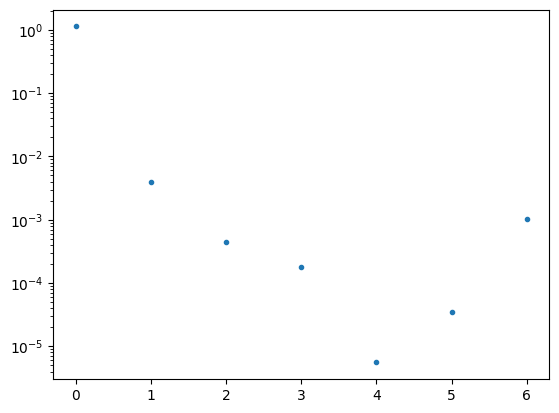

In [56]:
from matplotlib import pyplot as plt

plt.plot(abs(vect[0])**2,'.')
plt.yscale('log')

In [57]:
#@qml.qnode(devs[0])
#def krylov_vector(pauli_string,psi0):
#    qml.BasisState(psi0, wires=H_tapered.wires)
#    qml.apply(qml.pauli.string_to_pauli_word(pauli_string))
#    return qml.state()


#singles, doubles = qml.qchem.excitations(n_electrons, len(H.wires))
#print('singles', len(singles), 'doubles ', len(doubles))
#tapered_doubles = [
#    qml.taper_operation(qml.DoubleExcitation, generators, paulixops, paulix_sector,
#                        wire_order=H.wires, op_wires=double) for double in doubles
#]
#tapered_singles = [
#    qml.taper_operation(qml.SingleExcitation, generators, paulixops, paulix_sector,
#                        wire_order=H.wires, op_wires=single) for single in singles
#]

#dev = qml.device("default.qubit", wires=H_tapered.wires)
#@qml.qnode(dev)
#def tapered_circuit(params):
#    qml.BasisState(state_tapered, wires=H_tapered.wires)
#    for idx, tapered_op in enumerate(tapered_doubles + tapered_singles):
#        tapered_op(params[idx])
#    return qml.expval(H_tapered)

#state_tapered = qml.qchem.taper_hf(generators, paulixops, paulix_sector,
#                                   num_electrons=n_electrons, num_wires=len(H.wires))


#with open('params_vqe.pkl','rb') as f:
#    params = pickle.load(f)


#@qml.qnode(devs[0])
#def krylov_vector(pauli_string):
#    qml.BasisState(state_tapered, wires=H_tapered.wires)
#    for idx, tapered_op in enumerate(tapered_doubles + tapered_singles):
#        tapered_op(params[idx])
    
#    qml.apply(qml.pauli.string_to_pauli_word(pauli_string))
#    return qml.state()

#krylov_list = np.zeros(len(extract_basis))
#for i,pw in enumerate(extract_basis):
#    krylov_list[i] = krylov_vector(pw) * vect[i]


In [58]:
newstate = np.sum(krylov_list)
print((np.matmul(newstate.conj().transpose(),np.matmul(H_mat, newstate))/ np.matmul(newstate.conj().transpose(),newstate)) )

NameError: name 'krylov_list' is not defined

In [ ]:
H_tapered_sparse = qml.SparseHamiltonian(qml.utils.sparse_hamiltonian(H_tapered), wires=H_tapered.wires)

print("\nEigenvalues of H_tapered:\n", min(qml.eigvals(H_tapered_sparse, k=2**7)))


Eigenvalues of H_tapered:
 -15.594837897441854


In [ ]:
alpha = vect[0] #/np.sqrt(np.sum(np.abs(vects[0])**2))
print(alpha)

[1.+0.j]


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (8).

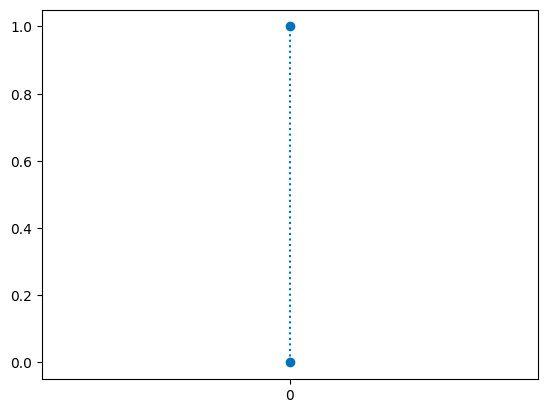

In [ ]:
for i in range(len(alpha)):
    plt.plot([i,i],[0,abs(alpha[i])**2],':o', color=[0, 0.4470, 0.7410])
plt.xticks(range(len(alpha)), labels=basis)
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()